In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import os
import torchvision.transforms as tt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from skimage.color import lab2rgb, rgb2lab
import torch.nn as nn
import torch.nn.functional as F
from skimage.color import rgb2lab, lab2rgb
from torchvision import models
from PIL import Image

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


device = get_default_device()


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 128 x 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 128 x 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128 x 128 x 128 x 128

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128 x 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 128 x 256 x 64 x 64

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 128 x 256 x 32 x 32

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 128 x 512 x 32 x 32

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 128 x 512 x 32 x 32

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh()
        )
        # 128 x 256 x 32 x 32

    def forward(self, x):
        return self.encoder(x.float())


In [4]:
class Feature_Extraction(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inv3_img, enc_img):
        y = torch.stack([torch.stack([inv3_img], dim=2)], dim=3)
        y = y.repeat(1, 1, enc_img.shape[2], enc_img.shape[3])
        fusion_img = torch.cat((enc_img, y), axis=1)
        return fusion_img


In [5]:
class After_Feature_Extraction(nn.Module):
    def __init__(self):
        super().__init__()
        self.ft = nn.Conv2d(1256, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, fusion_img):
        return self.ft(fusion_img)


In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            # 128 x 256 x 32 x 32

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0, mode='nearest'),
            # 128 x 128 x 64 x 64

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 128 x 64 x 64 x 64

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0, mode='nearest'),
            # 128 x 64 x 128 x 128

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0, mode='nearest'),
            # 128 x 32 x 256 x 256

            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(2),
            nn.Tanh()
            # 128 x 2 x 256 x 256
        )

    def forward(self, fuse_img):
        return self.decoder(fuse_img.float())


In [7]:
def rgb_to_lab(img):
    lab = rgb2lab(img.permute(0, 2, 3, 1).cpu().numpy())
    l = lab[:, :, :, 0]/50.0
    l = l.reshape(l.shape+(1,))  # Adding a new i.e color dimension
    ab = lab[:, :, :, 1:]/128
    return to_device(torch.tensor(l, dtype=torch.float).permute(0, 3, 1, 2), device), to_device(torch.tensor(ab, dtype=torch.float).permute(0, 3, 1, 2), device)


In [8]:
def stack_img(img):
    transform = tt.Resize(size=(299, 299))
    img = transform(img)
    img2 = img.repeat(1, 3, 1, 1)
    # img2=img2/128
    img2 = torch.tensor(img2)
    return img2


In [9]:
inception_v3 = to_device(models.inception_v3(pretrained=True), device)
inception_v3.aux_logits = False


C:\Users\KIIT\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\KIIT\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.ft_ex = Feature_Extraction()
        self.aft_ft_ex = After_Feature_Extraction()
        self.decoder = Decoder()

    def forward(self, L_img, test=False):
        inv3_img = inception_v3(stack_img(L_img))
        enc_img = self.encoder(L_img)
        fusion_img = self.ft_ex(inv3_img, enc_img)
        fusion_img = self.aft_ft_ex(fusion_img)
        dec_img = self.decoder(fusion_img)
        transform = tt.Resize(size=(256, 256))
        dec_img = transform(dec_img)
        return dec_img

    def training_step(self, batch):
        images, _ = batch
        L, AB = rgb_to_lab(images)
        out = self(L)  # 16 x 2 x 256 x 256
        loss = nn.MSELoss(reduction='mean')(out, AB)
        return loss

    def validation_step(self, batch):
        images, _ = batch
        L, AB = rgb_to_lab(images)
        out = self(L)
        loss = nn.MSELoss(reduction='mean')(out, AB)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))


In [11]:
model = BaseModel().to(device)
model


BaseModel(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [12]:
model.load_state_dict(torch.load('person2.pt', map_location='cpu'))


<All keys matched successfully>

In [13]:
def show_image(img, model):
    img = img.unsqueeze(0)  # 1 x 3 x 256 x 256
    L,AB=rgb_to_lab(img)
    print(L.shape)
    print(AB.shape)
    inception_v3.eval()
    output=(model(L))
    out=torch.cat((L,output),axis=1)
    out[:,0,:,:]=out[:,0,:,:]*50
    out[:,1:3,:,:]=out[:,1:3,:,:]*128
    return out.squeeze(0)

In [18]:
img=Image.open('pictures/pexels-konstantin-mishchenko-2010812.jpg')
transform=tt.Compose([
    tt.Resize((256,256)),
    tt.ToTensor()]
)
img=transform(img)
output=show_image(img,model)
output.shape
output=output.permute(1,2,0).detach().cpu().numpy()
color=lab2rgb(output)


torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])


C:\Users\KIIT\AppData\Local\Temp\ipykernel_19652\2155991526.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2 = torch.tensor(img2)


Text(0.5, 1.0, 'B/W')

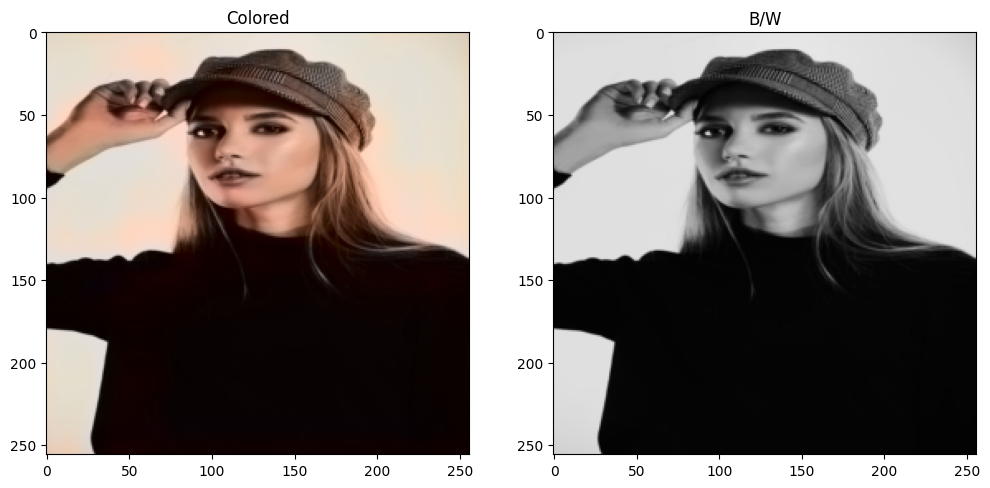

In [19]:
fig,ax=plt.subplots(1,2,figsize=(12,8))
ax[0].imshow(color)
ax[0].set_title("Colored")
ax[1].imshow(img.permute(1,2,0))
ax[1].set_title("B/W")